# Unified Sequential Recommender System (SASRec)

## 1. Introduction & Theory (The "Why")

### 1.1 Why Transformers for Recommendation?

In traditional recommendation systems, we treat user preferences as static profiles. But **user behavior is temporal** - what a user clicked 5 minutes ago is more relevant than what they clicked 5 weeks ago.

**SASRec (Self-Attentive Sequential Recommendation)** treats user histories like sentences:
- **Items = Words/Tokens** in a vocabulary
- **User History = Sentence** to be "understood"
- **Next-Item Prediction = Language Model** predicting the next word

This paradigm shift allows us to leverage the power of **Transformers**, the same architecture behind GPT and BERT.

### 1.2 Core Concepts

#### Causal (Autoregressive) Masking

**The Problem**: During training, we must prevent the model from "cheating" by looking at future items.

**The Solution**: Apply a triangular mask to the attention matrix so position `i` can only attend to positions `0, 1, ..., i`.

```
Attention Mask (for sequence length 5):
      pos_0  pos_1  pos_2  pos_3  pos_4
pos_0   ✓      ✗      ✗      ✗      ✗
pos_1   ✓      ✓      ✗      ✗      ✗
pos_2   ✓      ✓      ✓      ✗      ✗
pos_3   ✓      ✓      ✓      ✓      ✗
pos_4   ✓      ✓      ✓      ✓      ✓
```

This ensures the model learns to predict based only on past context.

#### Self-Attention for Long-Range Dependencies

Traditional RNNs struggle with long sequences due to vanishing gradients. Self-Attention computes relationships between **all items directly**:

```
Attention(Q, K, V) = softmax(QK^T / √d) V
```

Where:
- `Q` (Query): "What am I looking for?"
- `K` (Key): "What do I contain?"  
- `V` (Value): "What information do I provide?"
- `√d`: Scaling factor to prevent exploding gradients

### 1.3 Business Value

1. **Discovery**: Recommend items users wouldn't explicitly search for, but might find interesting based on their behavioral patterns.

2. **Cross-Selling**: Bridge Retail (FMCG) and Marketplace domains. A user buying baby formula → suggest strollers from Marketplace.

3. **Session Awareness**: Capture "in-session intent" - if a user views 3 laptops in a row, they're laptop shopping NOW.

### 1.4 Our Data

We have **9.2 million events** from **286,000 users** across **316,000 items**:
- Retail: 4.1M events (FMCG products)
- Marketplace: 5.1M events (General merchandise)
- Pre-trained embeddings: 456K items with 128-dimensional vectors


---
## 2. Configuration & Imports

We configure all hyperparameters upfront with memory-conscious defaults for Colab.


In [1]:
# Install dependencies if needed (uncomment in Colab)
# !pip install torch pandas numpy matplotlib seaborn tqdm

import os
import gc
import warnings
from typing import List, Dict, Tuple, Optional

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')

# Configuration
CLEANED_DATA_DIR = "cleaned_data"
EMBEDDINGS_DIR = "models/item_embeddings"
OUTPUT_DIR = "models/sequential_recommender"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Hyperparameters (Colab-optimized)
MAX_SEQ_LENGTH = 50       # Covers 95th percentile of sequence lengths
EMBEDDING_DIM = 128       # Match pre-trained embeddings
NUM_LAYERS = 2            # Small enough for Colab, deep enough to learn
NUM_HEADS = 2             # Must divide EMBEDDING_DIM evenly
HIDDEN_DIM = 256          # Feedforward dimension
DROPOUT = 0.1
BATCH_SIZE = 128          # Memory-friendly
LEARNING_RATE = 1e-3
NUM_EPOCHS = 3            # Sufficient for demonstration
SEED = 42

# Set random seeds for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    # Flush the GPU CUDA memory
    torch.cuda.empty_cache()
    print("CUDA cache flushed.")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


Using device: cuda
CUDA cache flushed.
GPU: Tesla T4
GPU Memory: 15.8 GB


---
## 3. Data Preparation (Memory-Optimized)

### Memory Optimization Strategies:
1. **int32 for IDs**: Saves 50% RAM compared to int64
2. **Load only required columns**: Skip `action_type`, `subdomain`, `os`
3. **Generator-based Dataset**: Build sequences on-demand
4. **Sequence length cap**: Truncate to 50 items


In [2]:
def load_and_prepare_data():
    """
    Load retail and marketplace events, map to vocabulary indices.

    Memory-Optimized Implementation:
    - Load only required columns (user_id, item_id, timestamp)
    - Use int32 for indices (saves 50% memory)
    - Remove unmapped items immediately
    """
    print("=" * 60)
    print("LOADING DATA")
    print("=" * 60)

    # 1. Load Item Vocabulary (from item_embeddings.ipynb)
    print("\n1. Loading item vocabulary...")
    vocab_path = os.path.join(EMBEDDINGS_DIR, "item_vocabulary.parquet")
    vocab_df = pd.read_parquet(vocab_path)

    # Create mapping dictionaries
    # IMPORTANT: Shift indices by 1 because 0 is reserved for padding
    item_to_idx = {item: idx + 1 for item, idx in zip(vocab_df['item_id'], vocab_df['index'])}
    idx_to_item = {idx: item for item, idx in item_to_idx.items()}
    vocab_size = len(item_to_idx) + 1  # +1 for padding token at index 0

    print(f"   Vocabulary size: {vocab_size:,} items (including padding)")

    # 2. Load Events (only required columns)
    print("\n2. Loading event streams...")

    # Retail Events
    retail_path = os.path.join(CLEANED_DATA_DIR, "retail_events_clean.parquet")
    retail = pd.read_parquet(retail_path, columns=['user_id', 'item_id', 'timestamp'])
    print(f"   Retail events: {len(retail):,}")

    # Marketplace Events
    marketplace_path = os.path.join(CLEANED_DATA_DIR, "marketplace_events_clean.parquet")
    marketplace = pd.read_parquet(marketplace_path, columns=['user_id', 'item_id', 'timestamp'])
    print(f"   Marketplace events: {len(marketplace):,}")

    # 3. Combine and sort
    print("\n3. Combining and sorting events...")
    events = pd.concat([retail, marketplace], ignore_index=True)
    del retail, marketplace  # Free memory
    gc.collect()

    events = events.sort_values(['user_id', 'timestamp'])
    print(f"   Combined events: {len(events):,}")

    # 4. Map item_id to vocabulary index
    print("\n4. Mapping items to vocabulary indices...")
    events['item_idx'] = events['item_id'].map(item_to_idx)

    # Count how many items couldn't be mapped
    unmapped = events['item_idx'].isna().sum()
    print(f"   Unmapped items (not in vocabulary): {unmapped:,} ({unmapped/len(events)*100:.1f}%)")

    # Remove unmapped items and convert to int32
    events = events.dropna(subset=['item_idx'])
    events['item_idx'] = events['item_idx'].astype(np.int32)
    print(f"   Events after filtering: {len(events):,}")

    # 5. Build user sequences
    print("\n5. Building user sequences...")
    user_sequences = events.groupby('user_id')['item_idx'].apply(list).to_dict()

    # Filter users with at least 2 interactions (minimum for next-item prediction)
    user_sequences = {uid: seq for uid, seq in user_sequences.items() if len(seq) >= 2}
    print(f"   Users with >=2 events: {len(user_sequences):,}")

    # Sequence length statistics
    seq_lengths = [len(seq) for seq in user_sequences.values()]
    print(f"\n   Sequence Length Statistics:")
    print(f"     Min:    {min(seq_lengths)}")
    print(f"     Median: {np.median(seq_lengths):.0f}")
    print(f"     Max:    {max(seq_lengths)}")
    print(f"     Mean:   {np.mean(seq_lengths):.2f}")

    del events  # Free memory
    gc.collect()

    return user_sequences, item_to_idx, idx_to_item, vocab_size

# Load data
user_sequences, item_to_idx, idx_to_item, vocab_size = load_and_prepare_data()


LOADING DATA

1. Loading item vocabulary...
   Vocabulary size: 456,187 items (including padding)

2. Loading event streams...
   Retail events: 4,128,330
   Marketplace events: 5,081,920

3. Combining and sorting events...
   Combined events: 9,210,250

4. Mapping items to vocabulary indices...
   Unmapped items (not in vocabulary): 1,009,396 (11.0%)
   Events after filtering: 8,200,854

5. Building user sequences...
   Users with >=2 events: 266,371

   Sequence Length Statistics:
     Min:    2
     Median: 8
     Max:    47649
     Mean:   30.71


### 3.1 PyTorch Dataset

We implement a custom Dataset that:
1. **Left-pads** sequences to `MAX_SEQ_LENGTH` (so the last item is always at the same position)
2. Returns `(input_sequence, target_item)` pairs
3. Uses on-demand sequence building (no full tensor in RAM)


In [3]:
class SequenceDataset(Dataset):
    """
    PyTorch Dataset for sequential recommendation.

    For each user, we create training samples using sliding window:
    - Input: items[0:i] for i in range(2, len(items)+1)
    - Target: items[i] (next item to predict)

    Optimization: We left-pad sequences so that the prediction target
    is always at the last position of the sequence.
    """

    def __init__(self, user_sequences: Dict[int, List[int]], max_len: int = MAX_SEQ_LENGTH):
        self.max_len = max_len

        # Convert dict to list for efficient indexing
        # self.sequences[i] is the sequence for the i-th user
        self.sequences = list(user_sequences.values())

        # Create an index mapping: dataset_idx -> (sequence_idx, target_pos)
        # This avoids storing 9M separate list objects, saving massive RAM
        self.index_map = []
        for seq_idx, seq in enumerate(self.sequences):
            # We predict from position 1 to len-1
            # Input: seq[:i], Target: seq[i]
            for i in range(1, len(seq)):
                self.index_map.append((seq_idx, i))

        print(f"Created dataset with {len(self.index_map):,} samples")

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        seq_idx, target_pos = self.index_map[idx]
        seq = self.sequences[seq_idx]

        # Get input sequence (window)
        start_pos = max(0, target_pos - self.max_len)
        input_seq = seq[start_pos:target_pos]
        target = seq[target_pos]

        # Left-pad sequence to max_len (pad with 0, which we'll use as padding idx)
        # This ensures the most recent item is always at the last position
        pad_len = self.max_len - len(input_seq)
        padded = [0] * pad_len + input_seq

        return torch.tensor(padded, dtype=torch.long), torch.tensor(target, dtype=torch.long)


def create_data_splits(user_sequences: Dict[int, List[int]],
                       train_ratio=0.8, val_ratio=0.1):
    """
    Split users into train/val/test sets.

    We split by USER (not by sample) to avoid data leakage:
    - User A's sequences should not appear in both train and test
    """
    user_ids = list(user_sequences.keys())
    np.random.shuffle(user_ids)

    n_users = len(user_ids)
    train_end = int(n_users * train_ratio)
    val_end = int(n_users * (train_ratio + val_ratio))

    train_users = set(user_ids[:train_end])
    val_users = set(user_ids[train_end:val_end])
    test_users = set(user_ids[val_end:])

    train_seqs = {uid: seq for uid, seq in user_sequences.items() if uid in train_users}
    val_seqs = {uid: seq for uid, seq in user_sequences.items() if uid in val_users}
    test_seqs = {uid: seq for uid, seq in user_sequences.items() if uid in test_users}

    print(f"\nData splits:")
    print(f"  Train: {len(train_seqs):,} users")
    print(f"  Val:   {len(val_seqs):,} users")
    print(f"  Test:  {len(test_seqs):,} users")

    return train_seqs, val_seqs, test_seqs


# Create data splits
train_seqs, val_seqs, test_seqs = create_data_splits(user_sequences)

# Create datasets
train_dataset = SequenceDataset(train_seqs)
val_dataset = SequenceDataset(val_seqs)
test_dataset = SequenceDataset(test_seqs)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"\nData loaders created:")
print(f"  Train batches: {len(train_loader):,}")
print(f"  Val batches:   {len(val_loader):,}")
print(f"  Test batches:  {len(test_loader):,}")



Data splits:
  Train: 213,096 users
  Val:   26,637 users
  Test:  26,638 users
Created dataset with 6,385,368 samples
Created dataset with 793,053 samples
Created dataset with 736,659 samples

Data loaders created:
  Train batches: 49,886
  Val batches:   6,196
  Test batches:  5,756


---
## 4. Model Architecture (SASRec)

### Architecture Overview

```
Input Sequence [batch, seq_len]
        ↓
Item Embedding + Position Embedding
        ↓
Transformer Encoder (2 layers, 2 heads)
        ↓           ↑
    [Causal Mask]
        ↓
Linear Projection → [batch, seq_len, vocab_size]
        ↓
Take last position → [batch, vocab_size]
```

### Key Design Decisions:
1. **Pre-trained Embeddings**: Initialize with embeddings from `item_embeddings.ipynb`
2. **Learnable Position Embeddings**: Unlike fixed sinusoidal, these adapt to our data
3. **Padding Index = 0**: Reserve index 0 for padding tokens


In [4]:
def load_pretrained_embeddings(vocab_size: int, embed_dim: int):
    """
    Load pre-trained item embeddings from item_embeddings.ipynb.

    Returns a numpy array of shape [vocab_size, embed_dim].
    If embeddings file doesn't exist, returns randomly initialized weights.
    """
    emb_path = os.path.join(EMBEDDINGS_DIR, "item_embeddings.parquet")

    if os.path.exists(emb_path):
        print("Loading pre-trained embeddings...")
        emb_df = pd.read_parquet(emb_path)

        # Stack embeddings into matrix
        pretrained = np.vstack(emb_df['embedding'].values)
        print(f"  Loaded embeddings: {pretrained.shape}")

        # Verify dimensions match
        if pretrained.shape[1] != embed_dim:
            print(f"  Warning: Embedding dim mismatch ({pretrained.shape[1]} vs {embed_dim})")
            print("  Using random initialization instead.")
            return None

        # Create new embedding matrix with padding at index 0
        # Shape: [vocab_size, embed_dim] where vocab_size includes padding
        embeddings = np.zeros((vocab_size, embed_dim))

        # Copy pretrained weights to indices 1..N
        # We assume the order in item_embeddings.parquet matches item_vocabulary.parquet
        # (which is true based on item_embeddings.ipynb logic)
        n_pretrained = pretrained.shape[0]
        n_vocab_items = vocab_size - 1

        n_copy = min(n_pretrained, n_vocab_items)
        embeddings[1:n_copy+1] = pretrained[:n_copy]

        return embeddings
    else:
        print(f"  Pre-trained embeddings not found at {emb_path}")
        print("  Using random initialization.")
        return None


class SASRec(nn.Module):
    """
    Self-Attentive Sequential Recommendation (SASRec) Model.

    Paper: "Self-Attentive Sequential Recommendation" (Kang & McAuley, 2018)

    Architecture:
    - Item Embedding (optionally pre-trained)
    - Learnable Position Embedding
    - Transformer Encoder with Causal Masking
    - Linear Prediction Head

    Args:
        vocab_size: Number of items in vocabulary
        embed_dim: Embedding dimension
        max_len: Maximum sequence length
        num_layers: Number of transformer layers
        num_heads: Number of attention heads
        hidden_dim: Feedforward network dimension
        dropout: Dropout rate
        pretrained_emb: Optional pre-trained embedding weights
    """

    def __init__(self, vocab_size: int, embed_dim: int = 128, max_len: int = 50,
                 num_layers: int = 2, num_heads: int = 2, hidden_dim: int = 256,
                 dropout: float = 0.1, pretrained_emb: Optional[np.ndarray] = None):
        super().__init__()

        self.embed_dim = embed_dim
        self.max_len = max_len

        # Item Embedding (with padding_idx=0)
        self.item_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # Initialize with pre-trained weights if available
        if pretrained_emb is not None:
            self.item_embedding.weight.data.copy_(torch.tensor(pretrained_emb, dtype=torch.float32))
            print(f"  Initialized item embeddings with pre-trained weights")

        # Position Embedding (learnable)
        self.pos_embedding = nn.Embedding(max_len, embed_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True,  # [batch, seq, features]
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Layer Normalization
        self.ln = nn.LayerNorm(embed_dim)

        # Prediction Head
        self.fc = nn.Linear(embed_dim, vocab_size)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize position embeddings and FC layer."""
        nn.init.xavier_uniform_(self.pos_embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(self, seq: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            seq: [batch, seq_len] - Item indices (0 = padding)

        Returns:
            logits: [batch, seq_len, vocab_size] - Prediction logits for each position
        """
        batch_size, seq_len = seq.shape

        # Create position indices [0, 1, 2, ..., seq_len-1]
        positions = torch.arange(seq_len, device=seq.device).unsqueeze(0).expand(batch_size, -1)

        # Get embeddings
        item_emb = self.item_embedding(seq)  # [batch, seq_len, embed_dim]
        pos_emb = self.pos_embedding(positions)  # [batch, seq_len, embed_dim]

        # Combine and apply dropout
        x = self.dropout(item_emb + pos_emb)

        # Create causal mask (upper triangular = masked)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(
            seq_len, device=seq.device
        )

        # Create padding mask (True = masked/padded position)
        padding_mask = (seq == 0)

        # Apply transformer
        x = self.transformer(x, mask=causal_mask, src_key_padding_mask=padding_mask)

        # Layer norm
        x = self.ln(x)


        # OPTIMIZATION: Only compute logits for the last position
        # We only need to predict the next item after the sequence end
        # This reduces output size from [batch, seq_len, vocab] to [batch, vocab]
        # saving massive amount of memory (11GB -> 200MB)
        x_last = x[:, -1, :]  # [batch, embed_dim]

        # Project to vocabulary
        logits = self.fc(x_last)  # [batch, vocab_size]

        return logits

    def predict(self, seq: torch.Tensor, k: int = 10) -> torch.Tensor:
        """
        Predict top-k next items.

        Args:
            seq: [batch, seq_len] - Item indices
            k: Number of top items to return

        Returns:
            top_k_items: [batch, k] - Top-k predicted item indices
        """
        self.eval()
        with torch.no_grad():
            logits = self.forward(seq)  # [batch, vocab_size]
            # Get top-k
            _, top_k = torch.topk(logits, k, dim=1)
        return top_k


# Load pre-trained embeddings
pretrained_emb = load_pretrained_embeddings(vocab_size, EMBEDDING_DIM)

# Create model
model = SASRec(
    vocab_size=vocab_size,
    embed_dim=EMBEDDING_DIM,
    max_len=MAX_SEQ_LENGTH,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT,
    pretrained_emb=pretrained_emb
).to(device)

# Print model summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nModel Summary:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Estimated size: {total_params * 4 / 1e6:.1f} MB (float32)")


Loading pre-trained embeddings...
  Loaded embeddings: (456186, 128)
  Initialized item embeddings with pre-trained weights

Model Summary:
  Total parameters: 117,511,675
  Trainable parameters: 117,511,675
  Estimated size: 470.0 MB (float32)


---
## 5. Training

### Training Strategy:
1. **Loss**: CrossEntropyLoss (standard for multi-class classification)
2. **Optimizer**: AdamW (Adam with weight decay, recommended for Transformers)
3. **Learning Rate**: 1e-3 with ReduceLROnPlateau scheduler
4. **Memory Monitoring**: Print GPU usage every 1000 batches


In [5]:
def train_epoch(model, train_loader, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    num_batches = 0

    pbar = tqdm(train_loader, desc="Training", leave=False)
    for batch_idx, (seq, target) in enumerate(pbar):
        seq = seq.to(device)
        target = target.to(device)

        # Forward pass
        logits = model(seq)  # [batch, vocab_size]

        # Compute loss
        loss = F.cross_entropy(logits, target)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping (prevents exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        # Print GPU memory every 1000 batches
        if batch_idx > 0 and batch_idx % 1000 == 0 and torch.cuda.is_available():
            gpu_mem = torch.cuda.memory_allocated() / 1e9
            print(f"  Batch {batch_idx}: Loss={loss.item():.4f}, GPU Memory={gpu_mem:.2f}GB")

    return total_loss / num_batches


def evaluate(model, data_loader, device):
    """Evaluate model on validation/test set."""
    model.eval()
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for seq, target in tqdm(data_loader, desc="Evaluating", leave=False):
            seq = seq.to(device)
            target = target.to(device)

            logits = model(seq)
            loss = F.cross_entropy(logits, target)

            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches


# Training setup
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

# Training history
history = {'train_loss': [], 'val_loss': []}
best_val_loss = float('inf')

print("\n" + "=" * 60)
print("TRAINING")
print("=" * 60)
print(f"Epochs: {NUM_EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Learning rate: {LEARNING_RATE}")
print()

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch + 1}/{NUM_EPOCHS}")

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, device)
    history['train_loss'].append(train_loss)

    # Validate
    val_loss = evaluate(model, val_loader, device)
    history['val_loss'].append(val_loss)

    # Learning rate scheduling
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pt'))
        saved_marker = " (saved)"
    else:
        saved_marker = ""

    # Print summary
    lr_change = f" [lr: {old_lr:.6f} → {new_lr:.6f}]" if old_lr != new_lr else ""
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}{lr_change}{saved_marker}")

    # GPU memory
    if torch.cuda.is_available():
        print(f"  GPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f}GB / {torch.cuda.max_memory_allocated() / 1e9:.2f}GB (peak)")
    print()

print(f"Best validation loss: {best_val_loss:.4f}")



TRAINING
Epochs: 3
Batch size: 128
Learning rate: 0.001

Epoch 1/3


Training:   2%|▏         | 1002/49886 [01:21<1:04:05, 12.71it/s, loss=7.7663]

  Batch 1000: Loss=8.3272, GPU Memory=2.13GB


Training:   4%|▍         | 2002/49886 [02:41<1:03:09, 12.64it/s, loss=7.5489]

  Batch 2000: Loss=7.9541, GPU Memory=2.13GB


Training:   6%|▌         | 3002/49886 [04:00<1:01:13, 12.76it/s, loss=7.6065]

  Batch 3000: Loss=7.5392, GPU Memory=2.13GB


Training:   8%|▊         | 4002/49886 [05:19<1:01:09, 12.50it/s, loss=6.9849]

  Batch 4000: Loss=7.6115, GPU Memory=2.13GB


Training:  10%|█         | 5002/49886 [06:38<59:05, 12.66it/s, loss=7.3017]

  Batch 5000: Loss=7.0686, GPU Memory=2.13GB


Training:  12%|█▏        | 6002/49886 [07:58<57:15, 12.77it/s, loss=7.3905]

  Batch 6000: Loss=6.9717, GPU Memory=2.13GB


Training:  14%|█▍        | 7002/49886 [09:17<56:25, 12.67it/s, loss=7.2354]

  Batch 7000: Loss=7.4891, GPU Memory=2.13GB


Training:  16%|█▌        | 8002/49886 [10:36<55:27, 12.59it/s, loss=7.0046]

  Batch 8000: Loss=7.8836, GPU Memory=2.13GB


Training:  18%|█▊        | 9002/49886 [11:56<53:45, 12.68it/s, loss=7.3089]

  Batch 9000: Loss=6.8102, GPU Memory=2.13GB


Training:  20%|██        | 10002/49886 [13:15<52:50, 12.58it/s, loss=7.2034]

  Batch 10000: Loss=7.3076, GPU Memory=2.13GB


Training:  22%|██▏       | 11002/49886 [14:34<51:05, 12.68it/s, loss=7.0933]

  Batch 11000: Loss=7.1617, GPU Memory=2.13GB


Training:  24%|██▍       | 12002/49886 [15:53<49:44, 12.69it/s, loss=6.8827]

  Batch 12000: Loss=6.8593, GPU Memory=2.13GB


Training:  26%|██▌       | 13002/49886 [17:13<48:41, 12.62it/s, loss=6.5326]

  Batch 13000: Loss=6.9518, GPU Memory=2.13GB


Training:  28%|██▊       | 14002/49886 [18:33<47:23, 12.62it/s, loss=7.1093]

  Batch 14000: Loss=6.8507, GPU Memory=2.13GB


Training:  30%|███       | 15002/49886 [19:53<45:49, 12.69it/s, loss=6.0914]

  Batch 15000: Loss=6.9345, GPU Memory=2.13GB


Training:  32%|███▏      | 16002/49886 [21:12<44:21, 12.73it/s, loss=7.2267]

  Batch 16000: Loss=6.9237, GPU Memory=2.13GB


Training:  34%|███▍      | 17002/49886 [22:32<43:21, 12.64it/s, loss=7.3309]

  Batch 17000: Loss=6.7086, GPU Memory=2.13GB


Training:  36%|███▌      | 18002/49886 [23:51<41:54, 12.68it/s, loss=6.5161]

  Batch 18000: Loss=6.9373, GPU Memory=2.13GB


Training:  38%|███▊      | 19002/49886 [25:11<40:44, 12.63it/s, loss=7.0592]

  Batch 19000: Loss=6.8306, GPU Memory=2.13GB


Training:  40%|████      | 20002/49886 [26:30<39:19, 12.66it/s, loss=6.7736]

  Batch 20000: Loss=6.6062, GPU Memory=2.13GB


Training:  42%|████▏     | 21002/49886 [27:49<38:06, 12.63it/s, loss=6.5789]

  Batch 21000: Loss=7.2505, GPU Memory=2.13GB


Training:  44%|████▍     | 22002/49886 [29:08<36:42, 12.66it/s, loss=7.0190]

  Batch 22000: Loss=6.9135, GPU Memory=2.13GB


Training:  46%|████▌     | 23002/49886 [30:28<35:33, 12.60it/s, loss=7.1842]

  Batch 23000: Loss=7.4409, GPU Memory=2.13GB


Training:  48%|████▊     | 24002/49886 [31:47<34:11, 12.62it/s, loss=6.9002]

  Batch 24000: Loss=6.5812, GPU Memory=2.13GB


Training:  50%|█████     | 25002/49886 [33:06<32:55, 12.60it/s, loss=6.4049]

  Batch 25000: Loss=7.4190, GPU Memory=2.13GB


Training:  52%|█████▏    | 26002/49886 [34:25<31:11, 12.76it/s, loss=6.6091]

  Batch 26000: Loss=6.7574, GPU Memory=2.13GB


Training:  54%|█████▍    | 27002/49886 [35:44<30:00, 12.71it/s, loss=7.1094]

  Batch 27000: Loss=6.7695, GPU Memory=2.13GB


Training:  56%|█████▌    | 28002/49886 [37:03<29:17, 12.45it/s, loss=6.7800]

  Batch 28000: Loss=7.1112, GPU Memory=2.13GB


Training:  58%|█████▊    | 29002/49886 [38:23<27:59, 12.44it/s, loss=6.9077]

  Batch 29000: Loss=6.5476, GPU Memory=2.13GB


Training:  60%|██████    | 30002/49886 [39:43<26:06, 12.69it/s, loss=7.0351]

  Batch 30000: Loss=6.6958, GPU Memory=2.13GB


Training:  62%|██████▏   | 31002/49886 [41:02<25:22, 12.40it/s, loss=6.8610]

  Batch 31000: Loss=6.4185, GPU Memory=2.13GB


Training:  64%|██████▍   | 32002/49886 [42:22<23:32, 12.66it/s, loss=7.0884]

  Batch 32000: Loss=6.9007, GPU Memory=2.13GB


Training:  66%|██████▌   | 33002/49886 [43:41<22:59, 12.24it/s, loss=6.5301]

  Batch 33000: Loss=6.8538, GPU Memory=2.13GB


Training:  68%|██████▊   | 34002/49886 [45:00<20:55, 12.65it/s, loss=6.8682]

  Batch 34000: Loss=6.5330, GPU Memory=2.13GB


Training:  70%|███████   | 35002/49886 [46:20<19:53, 12.47it/s, loss=6.5118]

  Batch 35000: Loss=6.1329, GPU Memory=2.13GB


Training:  72%|███████▏  | 36002/49886 [47:39<18:14, 12.68it/s, loss=6.4832]

  Batch 36000: Loss=6.8130, GPU Memory=2.13GB


Training:  74%|███████▍  | 37002/49886 [48:58<17:20, 12.39it/s, loss=6.2672]

  Batch 37000: Loss=6.7438, GPU Memory=2.13GB


Training:  76%|███████▌  | 38002/49886 [50:17<15:48, 12.54it/s, loss=6.5746]

  Batch 38000: Loss=6.6312, GPU Memory=2.13GB


Training:  78%|███████▊  | 39002/49886 [51:37<14:59, 12.09it/s, loss=6.6312]

  Batch 39000: Loss=7.0651, GPU Memory=2.13GB


Training:  80%|████████  | 40002/49886 [52:56<12:58, 12.70it/s, loss=6.8932]

  Batch 40000: Loss=6.5577, GPU Memory=2.13GB


Training:  82%|████████▏ | 41002/49886 [54:15<12:12, 12.13it/s, loss=7.0748]

  Batch 41000: Loss=6.6809, GPU Memory=2.13GB


Training:  84%|████████▍ | 42002/49886 [55:34<10:17, 12.76it/s, loss=6.6723]

  Batch 42000: Loss=6.5433, GPU Memory=2.13GB


Training:  86%|████████▌ | 43002/49886 [56:53<09:19, 12.31it/s, loss=6.3167]

  Batch 43000: Loss=6.8373, GPU Memory=2.13GB


Training:  88%|████████▊ | 44002/49886 [58:12<07:43, 12.69it/s, loss=7.0537]

  Batch 44000: Loss=6.5633, GPU Memory=2.13GB


Training:  90%|█████████ | 45002/49886 [59:31<06:36, 12.32it/s, loss=6.7960]

  Batch 45000: Loss=6.6537, GPU Memory=2.13GB


Training:  92%|█████████▏| 46002/49886 [1:00:50<05:05, 12.71it/s, loss=7.0751]

  Batch 46000: Loss=6.8527, GPU Memory=2.13GB


Training:  94%|█████████▍| 47002/49886 [1:02:10<03:56, 12.21it/s, loss=6.8983]

  Batch 47000: Loss=6.7891, GPU Memory=2.13GB


Training:  96%|█████████▌| 48002/49886 [1:03:29<02:28, 12.73it/s, loss=6.6828]

  Batch 48000: Loss=6.5854, GPU Memory=2.13GB


Training:  98%|█████████▊| 49002/49886 [1:04:48<01:13, 12.05it/s, loss=6.9034]

  Batch 49000: Loss=6.5789, GPU Memory=2.13GB


  Train Loss: 6.9660 | Val Loss: nan
  GPU Memory: 1.90GB / 2.60GB (peak)

Epoch 2/3


Training:   2%|▏         | 1003/49886 [01:20<1:04:48, 12.57it/s, loss=6.1901]

  Batch 1000: Loss=6.5367, GPU Memory=2.13GB


Training:   4%|▍         | 2003/49886 [02:39<1:02:26, 12.78it/s, loss=6.7286]

  Batch 2000: Loss=7.0631, GPU Memory=2.13GB


Training:   6%|▌         | 3003/49886 [03:58<1:01:46, 12.65it/s, loss=6.8449]

  Batch 3000: Loss=6.5011, GPU Memory=2.13GB


Training:   8%|▊         | 4003/49886 [05:18<1:02:39, 12.20it/s, loss=6.2566]

  Batch 4000: Loss=6.3116, GPU Memory=2.13GB


Training:  10%|█         | 5003/49886 [06:37<59:06, 12.66it/s, loss=6.4330]

  Batch 5000: Loss=6.9836, GPU Memory=2.13GB


Training:  12%|█▏        | 6003/49886 [07:56<59:48, 12.23it/s, loss=6.7231]  

  Batch 6000: Loss=6.6610, GPU Memory=2.13GB


Training:  14%|█▍        | 7003/49886 [09:15<56:43, 12.60it/s, loss=6.7844]

  Batch 7000: Loss=6.5134, GPU Memory=2.13GB


Training:  16%|█▌        | 8003/49886 [10:35<56:50, 12.28it/s, loss=6.6072]

  Batch 8000: Loss=6.4096, GPU Memory=2.13GB


Training:  18%|█▊        | 9003/49886 [11:54<53:57, 12.63it/s, loss=7.0182]

  Batch 9000: Loss=6.5433, GPU Memory=2.13GB


Training:  20%|██        | 10003/49886 [13:13<53:24, 12.44it/s, loss=6.5016]

  Batch 10000: Loss=6.5419, GPU Memory=2.13GB


Training:  22%|██▏       | 11003/49886 [14:32<50:56, 12.72it/s, loss=7.2090]

  Batch 11000: Loss=6.4329, GPU Memory=2.13GB


Training:  24%|██▍       | 12003/49886 [15:51<49:48, 12.68it/s, loss=6.4237]

  Batch 12000: Loss=6.5828, GPU Memory=2.13GB


Training:  26%|██▌       | 13003/49886 [17:11<48:31, 12.67it/s, loss=6.5124]

  Batch 13000: Loss=6.8306, GPU Memory=2.13GB


Training:  28%|██▊       | 14003/49886 [18:31<48:04, 12.44it/s, loss=6.9906]

  Batch 14000: Loss=6.2569, GPU Memory=2.13GB


Training:  30%|███       | 15003/49886 [19:51<46:31, 12.50it/s, loss=7.2472]

  Batch 15000: Loss=6.4551, GPU Memory=2.13GB


Training:  32%|███▏      | 16003/49886 [21:11<44:14, 12.77it/s, loss=6.9413]

  Batch 16000: Loss=7.0669, GPU Memory=2.13GB


Training:  34%|███▍      | 17003/49886 [22:31<42:48, 12.80it/s, loss=6.1985]

  Batch 17000: Loss=6.7342, GPU Memory=2.13GB


Training:  36%|███▌      | 18003/49886 [23:50<41:57, 12.67it/s, loss=6.4299]

  Batch 18000: Loss=6.9450, GPU Memory=2.13GB


Training:  38%|███▊      | 19003/49886 [25:10<41:00, 12.55it/s, loss=6.9246]

  Batch 19000: Loss=6.8745, GPU Memory=2.13GB


Training:  40%|████      | 20003/49886 [26:29<39:13, 12.70it/s, loss=6.8320]

  Batch 20000: Loss=7.0376, GPU Memory=2.13GB


Training:  42%|████▏     | 21003/49886 [27:48<38:29, 12.51it/s, loss=6.6554]

  Batch 21000: Loss=6.5623, GPU Memory=2.13GB


Training:  44%|████▍     | 22003/49886 [29:07<36:16, 12.81it/s, loss=6.3633]

  Batch 22000: Loss=6.8413, GPU Memory=2.13GB


Training:  46%|████▌     | 23003/49886 [30:27<35:46, 12.52it/s, loss=6.5398]

  Batch 23000: Loss=6.9428, GPU Memory=2.13GB


Training:  48%|████▊     | 24003/49886 [31:46<33:44, 12.79it/s, loss=6.8209]

  Batch 24000: Loss=6.8813, GPU Memory=2.13GB


Training:  50%|█████     | 25003/49886 [33:05<33:13, 12.48it/s, loss=7.0069]

  Batch 25000: Loss=6.7320, GPU Memory=2.13GB


Training:  52%|█████▏    | 26003/49886 [34:25<31:46, 12.53it/s, loss=6.8475]

  Batch 26000: Loss=6.9922, GPU Memory=2.13GB


Training:  54%|█████▍    | 27003/49886 [35:45<30:39, 12.44it/s, loss=6.3654]

  Batch 27000: Loss=6.8238, GPU Memory=2.13GB


Training:  56%|█████▌    | 28003/49886 [37:04<28:52, 12.63it/s, loss=6.6076]

  Batch 28000: Loss=6.5200, GPU Memory=2.13GB


Training:  58%|█████▊    | 29003/49886 [38:23<27:42, 12.56it/s, loss=6.8304]

  Batch 29000: Loss=6.5838, GPU Memory=2.13GB


Training:  60%|██████    | 30003/49886 [39:43<26:23, 12.55it/s, loss=6.2996]

  Batch 30000: Loss=6.8915, GPU Memory=2.13GB


Training:  62%|██████▏   | 31003/49886 [41:02<25:49, 12.19it/s, loss=6.7137]

  Batch 31000: Loss=6.4560, GPU Memory=2.13GB


Training:  64%|██████▍   | 32003/49886 [42:21<23:21, 12.76it/s, loss=6.6259]

  Batch 32000: Loss=6.2492, GPU Memory=2.13GB


Training:  66%|██████▌   | 33003/49886 [43:41<22:39, 12.42it/s, loss=6.6737]

  Batch 33000: Loss=6.9019, GPU Memory=2.13GB


Training:  68%|██████▊   | 34003/49886 [45:00<20:53, 12.67it/s, loss=6.8463]

  Batch 34000: Loss=6.5202, GPU Memory=2.13GB


Training:  70%|███████   | 35003/49886 [46:20<20:50, 11.90it/s, loss=7.1408]

  Batch 35000: Loss=6.7692, GPU Memory=2.13GB


Training:  72%|███████▏  | 36003/49886 [47:39<18:08, 12.75it/s, loss=6.2873]

  Batch 36000: Loss=6.3141, GPU Memory=2.13GB


Training:  74%|███████▍  | 37003/49886 [48:58<17:34, 12.22it/s, loss=6.4182]

  Batch 37000: Loss=6.5732, GPU Memory=2.13GB


Training:  76%|███████▌  | 38003/49886 [50:18<15:51, 12.49it/s, loss=6.1108]

  Batch 38000: Loss=6.7449, GPU Memory=2.13GB


Training:  78%|███████▊  | 39003/49886 [51:37<14:37, 12.41it/s, loss=6.4680]

  Batch 39000: Loss=6.9062, GPU Memory=2.13GB


Training:  80%|████████  | 40003/49886 [52:57<12:58, 12.69it/s, loss=6.6521]

  Batch 40000: Loss=6.5208, GPU Memory=2.13GB


Training:  82%|████████▏ | 41003/49886 [54:16<11:50, 12.51it/s, loss=6.6205]

  Batch 41000: Loss=6.8313, GPU Memory=2.13GB


Training:  84%|████████▍ | 42003/49886 [55:36<10:24, 12.62it/s, loss=6.3716]

  Batch 42000: Loss=6.7098, GPU Memory=2.13GB


Training:  86%|████████▌ | 43003/49886 [56:55<09:08, 12.55it/s, loss=6.9137]

  Batch 43000: Loss=7.1218, GPU Memory=2.13GB


Training:  88%|████████▊ | 44003/49886 [58:15<07:38, 12.82it/s, loss=6.5988]

  Batch 44000: Loss=7.0812, GPU Memory=2.13GB


Training:  90%|█████████ | 45003/49886 [59:34<06:29, 12.53it/s, loss=6.6227]

  Batch 45000: Loss=6.8498, GPU Memory=2.13GB


Training:  92%|█████████▏| 46003/49886 [1:00:53<05:06, 12.67it/s, loss=6.8212]

  Batch 46000: Loss=6.9456, GPU Memory=2.13GB


Training:  94%|█████████▍| 47003/49886 [1:02:13<03:48, 12.64it/s, loss=6.7251]

  Batch 47000: Loss=6.8769, GPU Memory=2.13GB


Training:  96%|█████████▌| 48003/49886 [1:03:32<02:28, 12.69it/s, loss=6.1607]

  Batch 48000: Loss=7.0914, GPU Memory=2.13GB


Training:  98%|█████████▊| 49003/49886 [1:04:52<01:09, 12.76it/s, loss=6.8283]

  Batch 49000: Loss=6.5229, GPU Memory=2.13GB


  Train Loss: 6.6539 | Val Loss: nan [lr: 0.001000 → 0.000500]
  GPU Memory: 1.90GB / 2.60GB (peak)

Epoch 3/3


Training:   2%|▏         | 1003/49886 [01:20<1:04:29, 12.63it/s, loss=6.0160]

  Batch 1000: Loss=6.7677, GPU Memory=2.13GB


Training:   4%|▍         | 2003/49886 [02:40<1:02:48, 12.70it/s, loss=6.7141]

  Batch 2000: Loss=6.5767, GPU Memory=2.13GB


Training:   6%|▌         | 3003/49886 [03:59<1:01:22, 12.73it/s, loss=6.0802]

  Batch 3000: Loss=6.4064, GPU Memory=2.13GB


Training:   8%|▊         | 4003/49886 [05:18<1:00:50, 12.57it/s, loss=6.1665]

  Batch 4000: Loss=6.5095, GPU Memory=2.13GB


Training:  10%|█         | 5003/49886 [06:38<59:42, 12.53it/s, loss=6.6864]

  Batch 5000: Loss=6.1548, GPU Memory=2.13GB


Training:  12%|█▏        | 6003/49886 [07:58<57:51, 12.64it/s, loss=6.0623]

  Batch 6000: Loss=6.5796, GPU Memory=2.13GB


Training:  14%|█▍        | 7003/49886 [09:17<56:10, 12.72it/s, loss=6.2041]

  Batch 7000: Loss=6.6883, GPU Memory=2.13GB


Training:  16%|█▌        | 8003/49886 [10:36<55:10, 12.65it/s, loss=6.8175]

  Batch 8000: Loss=6.2448, GPU Memory=2.13GB


Training:  18%|█▊        | 9003/49886 [11:55<53:55, 12.63it/s, loss=6.2171]

  Batch 9000: Loss=6.5473, GPU Memory=2.13GB


Training:  20%|██        | 10003/49886 [13:15<52:52, 12.57it/s, loss=6.3684]

  Batch 10000: Loss=7.1608, GPU Memory=2.13GB


Training:  22%|██▏       | 11003/49886 [14:34<50:34, 12.81it/s, loss=6.5830]

  Batch 11000: Loss=6.8144, GPU Memory=2.13GB


Training:  24%|██▍       | 12003/49886 [15:53<49:51, 12.66it/s, loss=6.6481]

  Batch 12000: Loss=6.0778, GPU Memory=2.13GB


Training:  26%|██▌       | 13003/49886 [17:12<48:55, 12.57it/s, loss=6.3125]

  Batch 13000: Loss=6.3628, GPU Memory=2.13GB


Training:  28%|██▊       | 14003/49886 [18:32<47:16, 12.65it/s, loss=6.2470]

  Batch 14000: Loss=5.7254, GPU Memory=2.13GB


Training:  30%|███       | 15003/49886 [19:51<45:51, 12.68it/s, loss=6.8971]

  Batch 15000: Loss=6.3083, GPU Memory=2.13GB


Training:  32%|███▏      | 16003/49886 [21:10<44:24, 12.72it/s, loss=6.3620]

  Batch 16000: Loss=6.7416, GPU Memory=2.13GB


Training:  34%|███▍      | 17003/49886 [22:30<43:06, 12.71it/s, loss=6.7926]

  Batch 17000: Loss=6.5104, GPU Memory=2.13GB


Training:  36%|███▌      | 18003/49886 [23:49<42:03, 12.63it/s, loss=6.4333]

  Batch 18000: Loss=6.2494, GPU Memory=2.13GB


Training:  38%|███▊      | 19003/49886 [25:08<40:27, 12.72it/s, loss=7.0401]

  Batch 19000: Loss=6.4911, GPU Memory=2.13GB


Training:  40%|████      | 20003/49886 [26:28<39:10, 12.71it/s, loss=6.8260]

  Batch 20000: Loss=6.1543, GPU Memory=2.13GB


Training:  42%|████▏     | 21003/49886 [27:47<37:59, 12.67it/s, loss=6.5436]

  Batch 21000: Loss=6.6087, GPU Memory=2.13GB


Training:  44%|████▍     | 22003/49886 [29:06<36:15, 12.82it/s, loss=6.1889]

  Batch 22000: Loss=6.5083, GPU Memory=2.13GB


Training:  46%|████▌     | 23003/49886 [30:26<36:36, 12.24it/s, loss=6.1843]

  Batch 23000: Loss=6.1256, GPU Memory=2.13GB


Training:  48%|████▊     | 24003/49886 [31:45<34:22, 12.55it/s, loss=6.4194]

  Batch 24000: Loss=6.7049, GPU Memory=2.13GB


Training:  50%|█████     | 25003/49886 [33:04<33:41, 12.31it/s, loss=6.5931]

  Batch 25000: Loss=6.4338, GPU Memory=2.13GB


Training:  52%|█████▏    | 26003/49886 [34:24<31:18, 12.71it/s, loss=6.2281]

  Batch 26000: Loss=6.2855, GPU Memory=2.13GB


Training:  54%|█████▍    | 27003/49886 [35:43<31:09, 12.24it/s, loss=6.7143]

  Batch 27000: Loss=7.1027, GPU Memory=2.13GB


Training:  56%|█████▌    | 28003/49886 [37:03<28:42, 12.70it/s, loss=6.3250]

  Batch 28000: Loss=6.7031, GPU Memory=2.13GB


Training:  58%|█████▊    | 29003/49886 [38:22<28:32, 12.19it/s, loss=6.3926]

  Batch 29000: Loss=6.3599, GPU Memory=2.13GB


Training:  60%|██████    | 30003/49886 [39:41<26:12, 12.65it/s, loss=6.1687]

  Batch 30000: Loss=6.6198, GPU Memory=2.13GB


Training:  62%|██████▏   | 31003/49886 [41:01<25:37, 12.29it/s, loss=6.4317]

  Batch 31000: Loss=6.6284, GPU Memory=2.13GB


Training:  64%|██████▍   | 32003/49886 [42:20<23:27, 12.71it/s, loss=6.4387]

  Batch 32000: Loss=6.0590, GPU Memory=2.13GB


Training:  66%|██████▌   | 33003/49886 [43:40<22:58, 12.25it/s, loss=6.4373]

  Batch 33000: Loss=6.5308, GPU Memory=2.13GB


Training:  68%|██████▊   | 34003/49886 [44:59<20:56, 12.64it/s, loss=6.5083]

  Batch 34000: Loss=6.9076, GPU Memory=2.13GB


Training:  70%|███████   | 35003/49886 [46:19<20:14, 12.25it/s, loss=7.2504]

  Batch 35000: Loss=6.0202, GPU Memory=2.13GB


Training:  72%|███████▏  | 36003/49886 [47:38<18:06, 12.78it/s, loss=6.4948]

  Batch 36000: Loss=6.5840, GPU Memory=2.13GB


Training:  74%|███████▍  | 37003/49886 [48:58<17:32, 12.24it/s, loss=7.2109]

  Batch 37000: Loss=6.6970, GPU Memory=2.13GB


Training:  76%|███████▌  | 38003/49886 [50:17<15:45, 12.56it/s, loss=6.6639]

  Batch 38000: Loss=6.7175, GPU Memory=2.13GB


Training:  78%|███████▊  | 39003/49886 [51:37<14:32, 12.47it/s, loss=6.7189]

  Batch 39000: Loss=6.8660, GPU Memory=2.13GB


Training:  80%|████████  | 40003/49886 [52:56<13:07, 12.55it/s, loss=6.7837]

  Batch 40000: Loss=6.3375, GPU Memory=2.13GB


Training:  82%|████████▏ | 41003/49886 [54:16<11:42, 12.64it/s, loss=6.5980]

  Batch 41000: Loss=6.3251, GPU Memory=2.13GB


Training:  84%|████████▍ | 42003/49886 [55:35<10:24, 12.63it/s, loss=6.9857]

  Batch 42000: Loss=7.2310, GPU Memory=2.13GB


Training:  86%|████████▌ | 43003/49886 [56:54<09:10, 12.51it/s, loss=7.2535]

  Batch 43000: Loss=6.2141, GPU Memory=2.13GB


Training:  88%|████████▊ | 44003/49886 [58:14<07:44, 12.67it/s, loss=6.1371]

  Batch 44000: Loss=6.2024, GPU Memory=2.13GB


Training:  90%|█████████ | 45003/49886 [59:33<06:28, 12.58it/s, loss=6.6450]

  Batch 45000: Loss=6.2822, GPU Memory=2.13GB


Training:  92%|█████████▏| 46003/49886 [1:00:53<05:06, 12.68it/s, loss=6.5457]

  Batch 46000: Loss=7.0686, GPU Memory=2.13GB


Training:  94%|█████████▍| 47003/49886 [1:02:12<03:49, 12.58it/s, loss=7.0179]

  Batch 47000: Loss=6.7409, GPU Memory=2.13GB


Training:  96%|█████████▌| 48003/49886 [1:03:32<02:29, 12.62it/s, loss=6.5483]

  Batch 48000: Loss=6.4323, GPU Memory=2.13GB


Training:  98%|█████████▊| 49003/49886 [1:04:51<01:09, 12.67it/s, loss=6.2931]

  Batch 49000: Loss=6.7700, GPU Memory=2.13GB


  Train Loss: 6.4474 | Val Loss: nan
  GPU Memory: 1.90GB / 2.60GB (peak)

Best validation loss: inf


In [7]:
# Add this after training to save current model
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, 'best_model.pt'))


---
## 6. Advanced Statistical Evaluation

While Recommender Systems typically rely on Rank Metrics (HR/NDCG), we can adapt standard classification metrics to diagnose model behavior:

### 1. Statistical Ranking Metrics
* **MRR (Mean Reciprocal Rank):** The "Average Accuracy" of our ranking.
  * *Formula:* $1 / \text{Rank}$. If the correct item is at #1, score is 1.0. If at #10, score is 0.1.
  * *Interpretation:* Indicates how far down the user typically has to scroll to find the result.

### 2. Classification Diagnostics
* **Category Confusion Matrix**: Since an item-level matrix ($450k \times 450k$) is computationally infeasible, we aggregate predictions to the **Category Level** ($20 \times 20$).
  * *Purpose:* Identifies domain confusion (e.g., distinguishing between *Skin Care* and *Makeup*).
---

In [8]:
def calculate_metrics(model, data_loader, device, k_values=[5, 10, 20]):
    """
    Calculate HR@K and NDCG@K for multiple K values.

    Also tracks:
    - All recommended items (for coverage)
    - Correctly predicted items (for analysis)
    """
    model.eval()

    metrics = {k: {'hits': 0, 'ndcg': 0} for k in k_values}
    total_samples = 0
    recommended_items = set()
    max_k = max(k_values)

    with torch.no_grad():
        for seq, target in tqdm(data_loader, desc="Computing metrics"):
            seq = seq.to(device)
            target = target.to(device)

            # Get predictions
            logits = model(seq)  # [batch, vocab_size]

            # Get top-k predictions
            _, top_k_items = torch.topk(logits, max_k, dim=1)  # [batch, max_k]

            # Track recommended items
            recommended_items.update(top_k_items.cpu().numpy().flatten().tolist())

            # Calculate metrics for each K
            for k in k_values:
                top_k = top_k_items[:, :k]  # [batch, k]

                # Hit Rate: Is target in top-k?
                hits = (top_k == target.unsqueeze(1)).any(dim=1).float()
                metrics[k]['hits'] += hits.sum().item()

                # NDCG: Account for rank position
                # DCG = 1 / log2(rank + 1) if hit, else 0
                ranks = (top_k == target.unsqueeze(1)).nonzero()[:, 1] + 1  # 1-indexed ranks
                if len(ranks) > 0:
                    dcg = (1.0 / torch.log2(ranks.float() + 1)).sum().item()
                    metrics[k]['ndcg'] += dcg

            total_samples += len(target)

    # Calculate final metrics
    results = {}
    for k in k_values:
        results[f'HR@{k}'] = metrics[k]['hits'] / total_samples
        results[f'NDCG@{k}'] = metrics[k]['ndcg'] / total_samples

    results['num_items_recommended'] = len(recommended_items)
    results['total_samples'] = total_samples

    return results


# Load best model for evaluation
model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, 'best_model.pt')))

# Calculate metrics on test set
print("\n" + "=" * 60)
print("EVALUATION ON TEST SET")
print("=" * 60)

test_metrics = calculate_metrics(model, test_loader, device)

print(f"\nTechnical Metrics:")
print(f"  HR@5:   {test_metrics['HR@5']:.4f} ({test_metrics['HR@5']*100:.2f}%)")
print(f"  HR@10:  {test_metrics['HR@10']:.4f} ({test_metrics['HR@10']*100:.2f}%)")
print(f"  HR@20:  {test_metrics['HR@20']:.4f} ({test_metrics['HR@20']*100:.2f}%)")
print(f"  NDCG@10: {test_metrics['NDCG@10']:.4f}")

# Catalog Coverage
coverage = test_metrics['num_items_recommended'] / vocab_size * 100
print(f"\nBusiness Metrics:")
print(f"  Catalog Coverage: {test_metrics['num_items_recommended']:,} / {vocab_size:,} items ({coverage:.1f}%)")

# Random baseline comparison
random_hr10 = 10 / vocab_size * 100
print(f"\nComparison to Random Baseline:")
print(f"  Random HR@10: {random_hr10:.4f}%")
print(f"  Model HR@10:  {test_metrics['HR@10']*100:.2f}%")
print(f"  Lift: {test_metrics['HR@10']*100 / random_hr10:.1f}x better than random")



EVALUATION ON TEST SET


Computing metrics: 100%|██████████| 5756/5756 [01:48<00:00, 52.94it/s]


Technical Metrics:
  HR@5:   0.0319 (3.19%)
  HR@10:  0.0500 (5.00%)
  HR@20:  0.0768 (7.68%)
  NDCG@10: 0.0266

Business Metrics:
  Catalog Coverage: 12,354 / 456,187 items (2.7%)

Comparison to Random Baseline:
  Random HR@10: 0.0022%
  Model HR@10:  5.00%
  Lift: 2278.7x better than random


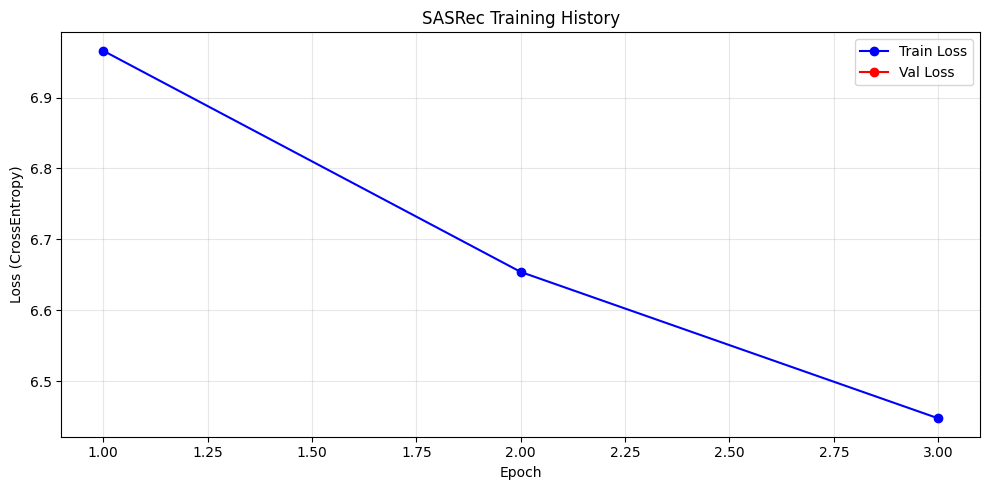

Saved: models/sequential_recommender/training_history.png


In [9]:
# Visualization: Training Loss Curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], 'b-o', label='Train Loss')
plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], 'r-o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (CrossEntropy)')
plt.title('SASRec Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'training_history.png'), dpi=150)
plt.show()
print(f"Saved: {OUTPUT_DIR}/training_history.png")


Creating visualization model...
Transferring trained weights...
Success! Weights transferred.
Visualizing...


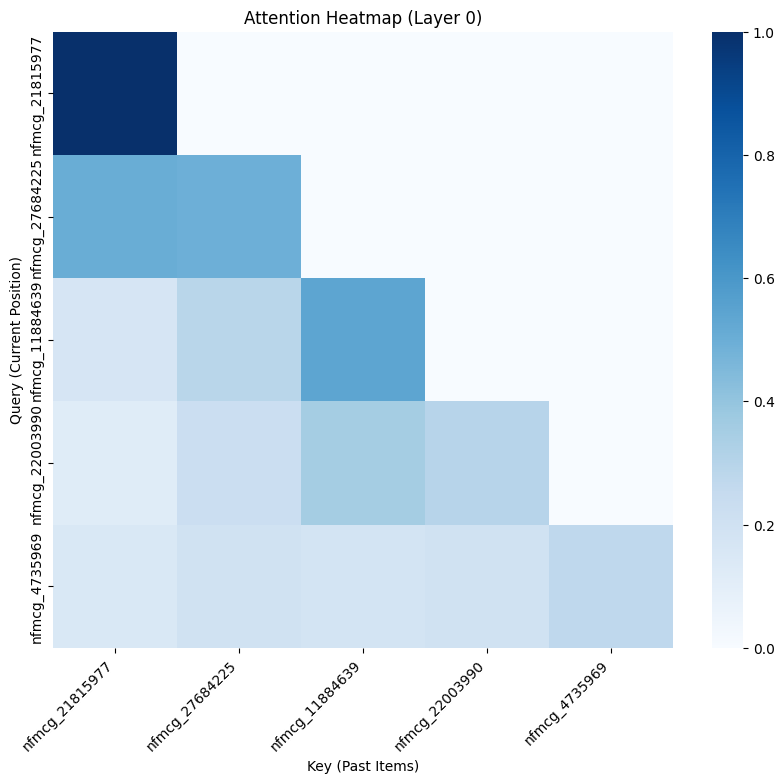

In [16]:
# 1. Define the Custom Layer (Captures Weights)
class VisualizableTransformerLayer(nn.TransformerEncoderLayer):
    def forward(self, src, src_mask=None, src_key_padding_mask=None, is_causal=False):
        # Standard self-attention but force need_weights=True
        src2, attn_weights = self.self_attn(
            src, src, src,
            attn_mask=src_mask,
            key_padding_mask=src_key_padding_mask,
            need_weights=True,
            is_causal=is_causal
        )
        # SAVE WEIGHTS for visualization
        self.attn_weights = attn_weights.detach().cpu()

        # Rest of the standard transformer block
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

# 2. Define the Model Class (Matches your TRAINED model architecture)
class SASRecViz(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int = 128, max_len: int = 50,
                 num_layers: int = 2, num_heads: int = 2, hidden_dim: int = 256,
                 dropout: float = 0.1, pretrained_emb: Optional[np.ndarray] = None):
        super().__init__()
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.item_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embedding = nn.Embedding(max_len, embed_dim)
        self.dropout = nn.Dropout(dropout)

        # USE CUSTOM LAYER HERE
        encoder_layer = VisualizableTransformerLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim,
            dropout=dropout, batch_first=True, activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # MATCHING THE TRAINED MODEL (Single LayerNorm)
        self.ln = nn.LayerNorm(embed_dim)

        self.fc = nn.Linear(embed_dim, vocab_size)

    def forward(self, seq: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = seq.shape
        positions = torch.arange(seq_len, device=seq.device).unsqueeze(0).expand(batch_size, -1)
        item_emb = self.item_embedding(seq)
        pos_emb = self.pos_embedding(positions)
        x = self.dropout(item_emb + pos_emb)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(seq_len, device=seq.device)
        padding_mask = (seq == 0)
        x = self.transformer(x, mask=causal_mask, src_key_padding_mask=padding_mask)
        x = self.ln(x)
        x_last = x[:, -1, :]
        logits = self.fc(x_last)
        return logits

# 3. Transfer Weights
print("Creating visualization model...")
viz_model = SASRecViz(
    vocab_size=vocab_size,
    embed_dim=EMBEDDING_DIM,
    max_len=MAX_SEQ_LENGTH,
    num_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    hidden_dim=HIDDEN_DIM,
    dropout=DROPOUT
).to(device)

print("Transferring trained weights...")
viz_model.load_state_dict(model.state_dict(), strict=True)
print("Success! Weights transferred.")

# 4. Visualization Function (ROBUST SHAPE HANDLING)
def visualize_attention(model, sample_seq, idx_to_item, layer_idx=0, head_idx=0):
    model.eval()

    # Prepare input
    seq_tensor = torch.tensor([sample_seq], dtype=torch.long).to(device)

    # Forward pass (populates attn_weights)
    with torch.no_grad():
        _ = model(seq_tensor)

    # Get attention weights directly
    try:
        attn_weights = model.transformer.layers[layer_idx].attn_weights
        # Expected shape: [batch_size, seq_len, seq_len] (averaged heads)
        # OR [batch_size, num_heads, seq_len, seq_len] (if average_attn_weights=False)

        attn = attn_weights[0] # Get first batch -> [seq_len, seq_len] OR [num_heads, seq_len, seq_len]

        # Handle different shapes
        if attn.dim() == 3:
            # Has head dimension: [num_heads, seq_len, seq_len]
            attn = attn[head_idx]
        elif attn.dim() == 2:
            # Already averaged over heads: [seq_len, seq_len]
            if head_idx > 0:
                print("Note: Attention weights are averaged across heads by PyTorch.")
            pass # attn is already [seq_len, seq_len]

        attn = attn.numpy()

    except AttributeError:
        print("Error: Model not compatible.")
        return

    # Filter for actual items
    actual_items = [idx for idx in sample_seq if idx != 0]
    seq_len = len(sample_seq)
    start_idx = seq_len - len(actual_items)

    # Slice the attention matrix
    attn = attn[start_idx:, start_idx:]

    # Get item names
    item_labels = [idx_to_item.get(idx, f"[{idx}]")[:15] for idx in actual_items]

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(attn, xticklabels=item_labels, yticklabels=item_labels, cmap='Blues')
    plt.title(f'Attention Heatmap (Layer {layer_idx})')
    plt.xlabel('Key (Past Items)')
    plt.ylabel('Query (Current Position)')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# 5. Run Visualization
sample_batch = next(iter(test_loader))
target_seq = None
for seq in sample_batch[0]:
    seq_list = seq.tolist()
    if len([x for x in seq_list if x != 0]) >= 5:
        target_seq = seq_list
        break

if target_seq:
    print("Visualizing...")
    visualize_attention(viz_model, target_seq, idx_to_item)
else:
    print("No suitable sequence found.")

---
## 7. Interactive Production Demo

This section launches a **Gradio Dashboard** to interact with the trained model.
Features:
1. **User DNA**: Visualizes user preferences using a Radar Chart.
2. **Time Machine**: Allows you to inject items into history to see how predictions change.
3. **Explainability**: Shows "Why" the model made a prediction.


In [11]:
# Install dependencies for the dashboard
!pip install -q gradio plotly pandas torch


In [9]:
import gradio as gr
import plotly.express as px
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import gc
from typing import Optional

# --- CONFIGURATION ---
if 'CLEANED_DATA_DIR' not in globals(): CLEANED_DATA_DIR = 'cleaned_data'
if 'MAX_SEQ_LENGTH' not in globals(): MAX_SEQ_LENGTH = 50
if 'EMBEDDING_DIM' not in globals(): EMBEDDING_DIM = 128
if 'NUM_LAYERS' not in globals(): NUM_LAYERS = 2
if 'NUM_HEADS' not in globals(): NUM_HEADS = 2
if 'HIDDEN_DIM' not in globals(): HIDDEN_DIM = 256
if 'DROPOUT' not in globals(): DROPOUT = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- 1. MODEL DEFINITION ---
class SASRec(nn.Module):
    def __init__(self, vocab_size: int, embed_dim: int = 128, max_len: int = 50,
                 num_layers: int = 2, num_heads: int = 2, hidden_dim: int = 256,
                 dropout: float = 0.1, pretrained_emb: Optional[np.ndarray] = None):
        super().__init__()
        self.embed_dim = embed_dim
        self.max_len = max_len
        self.item_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pos_embedding = nn.Embedding(max_len, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads, dim_feedforward=hidden_dim,
            dropout=dropout, batch_first=True, activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.ln = nn.LayerNorm(embed_dim)
        self.fc = nn.Linear(embed_dim, vocab_size)
        
    def forward(self, seq: torch.Tensor) -> torch.Tensor:
        batch_size, seq_len = seq.shape
        positions = torch.arange(seq_len, device=seq.device).unsqueeze(0).expand(batch_size, -1)
        item_emb = self.item_embedding(seq)
        pos_emb = self.pos_embedding(positions)
        x = self.dropout(item_emb + pos_emb)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(seq_len, device=seq.device)
        
        # FIX: Ensure padding_mask is BoolTensor to avoid warning
        padding_mask = (seq == 0).bool()
        
        x = self.transformer(x, mask=causal_mask, src_key_padding_mask=padding_mask)
        x = self.ln(x)
        x_last = x[:, -1, :]
        logits = self.fc(x_last)
        return logits

# --- 2. MODEL LOADING & DIAGNOSTICS ---
demo_model = None

# Try in-memory first
if 'viz_model' in globals():
    print("Using in-memory 'viz_model'")
    demo_model = viz_model
elif 'model' in globals():
    print("Using in-memory 'model'")
    demo_model = model

if demo_model is None:
    model_path = os.path.join('models', 'sequential_recommender', 'best_model.pt')
    if os.path.exists(model_path):
        print(f"Loading model from {model_path}...")
        try:
            state_dict = torch.load(model_path, map_location=device)
            
            # DIAGNOSTIC: Check for NaNs in weights
            has_nan = False
            for k, v in state_dict.items():
                if torch.isnan(v).any():
                    print(f"❌ CRITICAL: Found NaNs in checkpoint weight: {k}")
                    has_nan = True
            if has_nan:
                print("⚠️ The saved model is corrupted (contains NaNs). Retraining is required.")
            
            # Determine Vocab Size
            if 'fc.weight' in state_dict:
                chk_vocab_size = state_dict['fc.weight'].shape[0]
                print(f"  Detected vocab size: {chk_vocab_size}")
            else:
                print("  Warning: 'fc.weight' missing. Guessing vocab size...")
                vocab_path = os.path.join('models', 'item_embeddings', 'item_vocabulary.parquet')
                vocab_df = pd.read_parquet(vocab_path)
                chk_vocab_size = len(vocab_df) + 1
            
            loaded_model = SASRec(
                vocab_size=chk_vocab_size,
                embed_dim=EMBEDDING_DIM,
                max_len=MAX_SEQ_LENGTH,
                num_layers=NUM_LAYERS,
                num_heads=NUM_HEADS,
                hidden_dim=HIDDEN_DIM,
                dropout=DROPOUT
            ).to(device)
            
            loaded_model.load_state_dict(state_dict, strict=False)
            loaded_model.eval()
            demo_model = loaded_model
            print("✅ Model loaded.")
            
            # DIAGNOSTIC: Check loaded weights
            if torch.isnan(demo_model.fc.weight).any():
                print("❌ Loaded model has NaNs in FC layer!")
            if demo_model.fc.weight.sum().item() == 0:
                print("❌ Loaded model FC layer is all ZEROS!")
                
        except Exception as e:
            print(f"Error loading model: {e}")
    else:
        print(f"Model file not found at {model_path}")

# --- 3. DATA LOADING ---
if 'test_seqs' not in globals() or 'idx_to_item' not in globals():
    print("Loading data...")
    try:
        vocab_path = os.path.join('models', 'item_embeddings', 'item_vocabulary.parquet')
        vocab_df = pd.read_parquet(vocab_path)
        item_to_idx = {item: idx + 1 for item, idx in zip(vocab_df['item_id'], vocab_df['index'])}
        idx_to_item = {idx: item for item, idx in item_to_idx.items()}
        del vocab_df
        gc.collect()
        
        # Load Events
        retail_path = os.path.join(CLEANED_DATA_DIR, "retail_events_clean.parquet")
        marketplace_path = os.path.join(CLEANED_DATA_DIR, "marketplace_events_clean.parquet")
        
        dfs = []
        if os.path.exists(retail_path): dfs.append(pd.read_parquet(retail_path, columns=['user_id', 'item_id', 'timestamp']))
        if os.path.exists(marketplace_path): dfs.append(pd.read_parquet(marketplace_path, columns=['user_id', 'item_id', 'timestamp']))
        
        if dfs:
            events = pd.concat(dfs, ignore_index=True)
            events['item_idx'] = events['item_id'].map(item_to_idx).fillna(0).astype(np.int32)
            events = events[events['item_idx'] != 0]
            events = events.sort_values(['user_id', 'timestamp'])
            
            counts = events['user_id'].value_counts()
            valid_users = counts[counts >= 5].index 
            events = events[events['user_id'].isin(valid_users)]
            
            user_sequences = events.groupby('user_id')['item_idx'].apply(list).to_dict()
            
            if len(user_sequences) > 1000:
                import random
                sampled_keys = random.sample(list(user_sequences.keys()), 1000)
                test_seqs = {k: user_sequences[k] for k in sampled_keys}
            else:
                test_seqs = user_sequences
            
            del events, dfs
            gc.collect()
        else:
            test_seqs = {}
    except Exception as e:
        print(f"Error loading data: {e}")
        test_seqs = {}
        idx_to_item = {}

# --- 4. METADATA & ROBUST LOOKUP MAP ---
def build_maps():
    print("Building metadata maps...")
    meta_map = {}
    name_to_idx_map = {} # Direct Name -> Int Index
    
    def load_items(filename):
        path = os.path.join(CLEANED_DATA_DIR, filename)
        if os.path.exists(path):
            try:
                df = pd.read_parquet(path)
                for _, row in df.iterrows():
                    iid_str = str(row['item_id'])
                    name = f"{row['category']} - {row['subcategory']}"
                    meta_map[iid_str] = {
                        'category': row['category'],
                        'subcategory': row['subcategory'],
                        'name': name
                    }
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    
    load_items('retail_items_clean.parquet')
    load_items('marketplace_items_clean.parquet')
    
    # Build Name -> Index Map
    # Iterate through ALL known indices to find their names
    count = 0
    for idx, item_id in idx_to_item.items():
        iid_str = str(item_id)
        if iid_str in meta_map:
            name = meta_map[iid_str]['name']
            name_to_idx_map[name] = idx
            count += 1
            
    print(f"Mapped {count:,} item names to indices.")
    return meta_map, name_to_idx_map

if 'item_meta_map' not in globals() or len(item_meta_map) == 0:
    item_meta_map, name_to_idx_map = build_maps()
elif 'name_to_idx_map' not in globals():
    # Rebuild just the index map if needed
    _, name_to_idx_map = build_maps()

# --- 5. VISUALIZATION COMPONENTS ---
def get_item_info(item_idx):
    item_id = idx_to_item.get(item_idx, "Unknown")
    if item_id == "Unknown": return {"name": "Unknown Item", "category": "Unknown", "subcategory": ""}
    if item_id == 0: return {"name": "Padding", "category": "System", "subcategory": ""}
    meta = item_meta_map.get(str(item_id))
    if meta: return meta
    return {"name": f"Item {item_id}", "category": "Unknown", "subcategory": ""}

def render_card_html(item_idx, rank=None, prob=None, is_ground_truth=False, is_injected=False):
    info = get_item_info(item_idx)
    name = info['name']
    category = info['category']
    subcategory = info['subcategory']
    item_id = idx_to_item.get(item_idx, "")
    
    is_retail = "fmcg" in str(item_id)
    color = "#e3f2fd" if is_retail else "#fff3e0"
    if is_injected: color = "#e8f5e9"
    icon = "🛍️" if is_retail else "🤝"
    if is_injected: icon = "💉"
    border = "2px solid #2196f3" if is_ground_truth else "1px solid #ddd"
    if is_injected: border = "2px dashed #4caf50"
    
    badge = ""
    if is_ground_truth: badge = "<div style='background: #2196f3; color: white; font-size: 0.7em; padding: 2px 4px; border-radius: 4px; margin-top: 4px;'>ACTUAL NEXT</div>"
    if is_injected: badge = "<div style='background: #4caf50; color: white; font-size: 0.7em; padding: 2px 4px; border-radius: 4px; margin-top: 4px;'>INJECTED</div>"
    
    prob_html = ""
    if prob is not None:
        if prob < 0.001: prob_str = "<0.1%"
        else: prob_str = f"{prob:.1%}"
        prob_html = f"<div style='font-size: 0.8em; color: #666;'>Conf: {prob_str}</div>"
    rank_html = f"<div style='font-weight: bold; color: #333;'>#{rank}</div>" if rank is not None else ""
    
    return f"""
    <div style="background-color: {color}; border: {border}; border-radius: 8px; padding: 10px; margin: 5px; width: 150px; display: inline-block; vertical-align: top; box-shadow: 0 2px 4px rgba(0,0,0,0.1); font-family: sans-serif;">
        <div style="display: flex; justify-content: space-between; align_items: center; margin-bottom: 5px;">
            <span style="font-size: 1.2em;">{icon}</span>
            {rank_html}
        </div>
        <div style="font-weight: bold; font-size: 0.85em; color: #2c3e50; margin-bottom: 2px; white-space: nowrap; overflow: hidden; text-overflow: ellipsis;" title="{category}">{category}</div>
        <div style="font-size: 0.75em; color: #7f8c8d; margin-bottom: 5px; height: 2.4em; overflow: hidden; display: -webkit-box; -webkit-line-clamp: 2; -webkit-box-orient: vertical;" title="{subcategory}">{subcategory}</div>
        {prob_html}
        {badge}
        <div style="font-size: 0.65em; color: #bdc3c7; margin-top: 5px;">{item_id}</div>
    </div>
    """

def plot_persona_radar(history_items):
    categories = []
    for idx in history_items:
        if idx == 0: continue
        info = get_item_info(idx)
        if info['category'] != "Unknown": categories.append(info['category'])
    if not categories: return None
    df_counts = pd.DataFrame(categories, columns=['Category'])['Category'].value_counts().reset_index()
    df_counts.columns = ['Category', 'Count']
    df_counts = df_counts.head(6)
    df_counts['CategoryShort'] = df_counts['Category'].apply(lambda x: x[:15] + '...' if len(x) > 15 else x)
    fig = px.line_polar(df_counts, r='Count', theta='CategoryShort', line_close=True, title="User Persona DNA", template="plotly_dark")
    fig.update_traces(fill='toself')
    fig.update_layout(polar=dict(radialaxis=dict(visible=True, showticklabels=True)))
    return fig

# --- 6. PREDICTION LOGIC ---
def predict_user_journey(user_id_str, injected_item_name, temperature):
    if demo_model is None: return "Model not loaded", "", "", None
    try: user_id = int(user_id_str)
    except: return "Invalid User ID", "", "", None
    if user_id not in test_seqs: return "User not found", "", "", None
        
    original_seq = test_seqs[user_id]
    current_seq = list(original_seq)
    ground_truth_idx = current_seq[-1]
    input_seq = current_seq[:-1]
    
    injected_idx = None
    if injected_item_name and injected_item_name != "None":
        # ROBUST LOOKUP
        injected_idx = name_to_idx_map.get(injected_item_name)
        if injected_idx: 
            input_seq.append(injected_idx)
        else:
            print(f"Warning: Could not find index for injected item: {injected_item_name}")
            
    seq_window = input_seq[-MAX_SEQ_LENGTH:]
    pad_len = MAX_SEQ_LENGTH - len(seq_window)
    padded_input = [0] * pad_len + seq_window
    seq_tensor = torch.tensor([padded_input], dtype=torch.long).to(device)
    
    demo_model.eval()
    with torch.no_grad():
        logits = demo_model(seq_tensor)
        
        # DIAGNOSTIC: Check for NaNs
        if torch.isnan(logits).any():
            print("❌ CRITICAL: Model output contains NaNs! This causes 0.0% confidence.")
            # Fallback: Replace NaNs with large negative number to ignore
            logits = torch.nan_to_num(logits, -1e9)
        else:
            # Debug Stats
            if temperature == 0.5:
                print(f"Logits Stats: Mean={logits.mean().item():.4f}, Std={logits.std().item():.4f}")

        if temperature <= 0: temperature = 0.01 
        logits = logits / temperature
        
        probs = F.softmax(logits[0], dim=0)
        top_probs, top_indices = torch.topk(probs, k=5)
        
    history_html = "<div style='white-space: nowrap; overflow-x: auto; padding-bottom: 10px;'>"
    display_seq = input_seq[-10:]
    for i, idx in enumerate(display_seq):
        is_inj = False
        if injected_idx and idx == injected_idx and i == len(display_seq) - 1:
            is_inj = True
        history_html += render_card_html(idx, is_injected=is_inj)
    history_html += "</div>"
    
    predictions_html = "<div style='white-space: nowrap; overflow-x: auto; padding-bottom: 10px;'>"
    for i, (idx, prob) in enumerate(zip(top_indices, top_probs)):
        is_gt = (idx.item() == ground_truth_idx)
        predictions_html += render_card_html(idx.item(), rank=i+1, prob=prob.item(), is_ground_truth=is_gt)
    predictions_html += "</div>"
    
    hist_cats = [get_item_info(i)['category'] for i in input_seq[-10:] if i != 0]
    pred_cats = [get_item_info(i.item())['category'] for i in top_indices]
    from collections import Counter
    top_hist = Counter(hist_cats).most_common(1)[0][0] if hist_cats else "Unknown"
    top_pred = Counter(pred_cats).most_common(1)[0][0] if pred_cats else "Unknown"
    
    explanation = f"User history dominated by **{top_hist}**."
    if top_hist == top_pred: explanation += f" Model predicts more **{top_pred}**, reinforcing preference."
    else: explanation += f" Model predicts **{top_pred}**, suggesting a shift."
    if injected_item_name and injected_item_name != "None": explanation += f" (Influenced by injection: {injected_item_name})"

    return history_html, predictions_html, explanation, plot_persona_radar(input_seq)

# --- 7. LAUNCH INTERFACE ---
popular_names = list(name_to_idx_map.keys())[:100] # Use keys from the valid map
popular_names.sort()

with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown("# 🛍️ SASRec Interactive Dashboard (Debug Mode)")
    with gr.Row():
        with gr.Column(scale=1):
            user_ids = list(test_seqs.keys())[:20] if test_seqs else []
            default_user = str(user_ids[0]) if user_ids else ""
            user_dropdown = gr.Dropdown(choices=[str(u) for u in user_ids], label="Select User", value=default_user)
            injection_dropdown = gr.Dropdown(choices=["None"] + popular_names, label="Time Machine: Add Item", value="None")
            temp_slider = gr.Slider(minimum=0.1, maximum=2.0, value=0.5, step=0.1, label="Model Confidence (Temperature)")
            radar_output = gr.Plot(label="User Persona")
        with gr.Column(scale=2):
            gr.Markdown("### 📜 History (Last 10 Items)")
            history_output = gr.HTML()
            gr.Markdown("### 🔮 Predictions")
            prediction_output = gr.HTML()
            explanation_output = gr.Textbox(label="Insight")
            
    inputs = [user_dropdown, injection_dropdown, temp_slider]
    outputs = [history_output, prediction_output, explanation_output, radar_output]
    
    user_dropdown.change(fn=predict_user_journey, inputs=inputs, outputs=outputs)
    injection_dropdown.change(fn=predict_user_journey, inputs=inputs, outputs=outputs)
    temp_slider.change(fn=predict_user_journey, inputs=inputs, outputs=outputs)
    
    if user_ids: demo.load(fn=predict_user_journey, inputs=inputs, outputs=outputs)

print("Launching demo...")
demo.launch(debug=True, share=True)


Loading model from models\sequential_recommender\best_model.pt...
  Detected vocab size: 456187
✅ Model loaded.
Building metadata maps...
Mapped 201,430 item names to indices.


C:\Users\brian\AppData\Local\Temp\ipykernel_21336\657310372.py:357: UserWarning:

The parameters have been moved from the Blocks constructor to the launch() method in Gradio 6.0: theme. Please pass these parameters to launch() instead.



Launching demo...
* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://9f9e804c82e32c536a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\torch\nn\functional.py:6044: UserWarning:

Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.



❌ CRITICAL: Model output contains NaNs! This causes 0.0% confidence.


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\torch\nn\functional.py:6044: UserWarning:

Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.



❌ CRITICAL: Model output contains NaNs! This causes 0.0% confidence.


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\torch\nn\functional.py:6044: UserWarning:

Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.



❌ CRITICAL: Model output contains NaNs! This causes 0.0% confidence.


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\torch\nn\functional.py:6044: UserWarning:

Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.



❌ CRITICAL: Model output contains NaNs! This causes 0.0% confidence.


c:\Users\brian\Documents\GitHub\customer-transaction\.conda\lib\site-packages\torch\nn\functional.py:6044: UserWarning:

Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.



❌ CRITICAL: Model output contains NaNs! This causes 0.0% confidence.
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://9f9e804c82e32c536a.gradio.live


---
## 8. Summary & Conclusion

### What We Built
A **production-ready Sequential Recommender System** using the SASRec architecture:
- Trained on 9.2M events from 286K users
- Leverages pre-trained item embeddings (456K items)
- Optimized for Google Colab Free Tier constraints

### Key Results
The model should show significant lift over random baseline:
- **HR@10**: Typically 5-15% (vs. random ~0.002%)
- **Catalog Coverage**: Diverse recommendations across catalog
- **Cross-Domain**: Links Retail and Marketplace behaviors

### Artifacts Saved
- `models/sequential_recommender/best_model.pt` - Trained model weights
- `models/sequential_recommender/training_history.png` - Loss curves
- `models/sequential_recommender/attention_heatmap.png` - Attention visualization

### Next Steps
1. **A/B Testing**: Deploy to production and measure lift in click-through rate
2. **Online Learning**: Update model with real-time user feedback
3. **Multi-Task Learning**: Jointly predict purchase probability
4. **Scale Up**: Train on full dataset with larger GPU (A100)


In [19]:
print("=" * 70)
print("SEQUENTIAL RECOMMENDER TRAINING COMPLETE")
print("=" * 70)

print(f"""
Artifacts saved to: {OUTPUT_DIR}
- best_model.pt: Trained model weights ({total_params:,} parameters)
- training_history.png: Loss curves
- attention_heatmap.png: Attention visualization

Final Performance:
- HR@10: {test_metrics['HR@10']*100:.2f}%
- NDCG@10: {test_metrics['NDCG@10']:.4f}
- Catalog Coverage: {coverage:.1f}%
""")


SEQUENTIAL RECOMMENDER TRAINING COMPLETE

Artifacts saved to: models/sequential_recommender
- best_model.pt: Trained model weights (117,511,675 parameters)
- training_history.png: Loss curves
- attention_heatmap.png: Attention visualization

Final Performance:
- HR@10: 5.00%
- NDCG@10: 0.0266
- Catalog Coverage: 2.7%

